In [26]:
# We create a file where all images will be stored

data_dir = './64'
import helpers
import math
import os
import sys
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil
import glob

import numpy as np
from PIL import Image
from tqdm import tqdm


In [27]:
print(os.getcwd())

/home/ubuntu/poster_generator


In [28]:
from PIL import Image
import os
import glob

# NOTE
# Helper Cell Create Thumbnail fith images




# TODO: Get images from ./data recursively.
# data_dir = '.'
# size = (64, 64)

# for f in os.listdir('.'):
#     if f.endswith('.jpg'):
#         i = Image.open(f)
#         rgb_im = i.convert('RGB')
#         rgb_im.save(f)
#         i = Image.open(f)
#         i.thumbnail(size, Image.ANTIALIAS)
#         fn, fext = os.path.splitext(f)
#         i.save('64/{}64{}'.format(fn, fext))

# Use command line to mv ./240/* ./
# Apply this snippet and aft



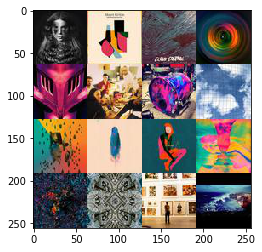

In [29]:
show_n_images = 20


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np
import math

poster_images = helpers.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helpers.images_square_grid(poster_images, 'RGB'))

## Check GPU Version

In [30]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [31]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim = (image_width ,image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

### Discriminator

In [48]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64x64x3
#         print("number of images in discriminator",images)
        x = tf.layers.conv2d(images, 64, 5, strides=(2, 2), padding='same')
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # Now 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 4x4x256
        
        # Flatten to 1D tensor
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        # Now 4x4x256
        logits = tf.layers.dense(x, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits



### Generator

In [63]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 4 * 4 * 1024)
        # Reshape tensor with -1 to flaten into a 1d
        x = tf.reshape(x, (-1, 4, 4, 256))
        # Batch Norm
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # now 4x4x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=(4, 4), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 16x16x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 32x32x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        print("image shape in discriminator",x.shape)
        # now 64x64x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=(1, 1), padding='same')
        output = tf.tanh(logits)
        # now 64x64x3
        
        return output



### Loss

In [64]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

### Optimization

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt




## Neural Network Training

### Show Output

In [66]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helpers.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

In [107]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build Model    
    # Reset number of steps
    samples, losses = [], []
    steps = 0
    
    # Print training data
    print_every = 10
    show_every = 100
    
    # Pass dim 3 or 1 depending if images have color or not
    if (data_image_mode == 'RGB'):
        out_channel_dim=3
    else:
        out_channel_dim=1
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # Restore variables from disk.
        saver.restore(sess, "./tmp/model-64.ckpt")
        print("Model restored.")
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # The values of the Posters dataset will be in the range of -0.5 to 0.5 of 240x240 
                # dimensional images fot fit our random uniform we multiply by 1.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
                    # Save the variables to disk.
                    save_path = saver.save(sess, "./tmp/model-64.ckpt")
                    print("Model saved in path: %s" % save_path)

        
        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
        return losses, samples
                
                

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

### Poster

image shape in discriminator (?, 64, 64, 64)
INFO:tensorflow:Restoring parameters from ./tmp/model-64.ckpt
Model restored.
Epoch 2/500... Discriminator Loss: 0.8522... Generator Loss: 0.6996
Epoch 3/500... Discriminator Loss: 0.4524... Generator Loss: 1.7466
Epoch 4/500... Discriminator Loss: 0.4075... Generator Loss: 1.7602
Epoch 5/500... Discriminator Loss: 0.3490... Generator Loss: 1.9151
Epoch 7/500... Discriminator Loss: 0.3543... Generator Loss: 1.7614
Epoch 8/500... Discriminator Loss: 0.3793... Generator Loss: 1.7883
Epoch 9/500... Discriminator Loss: 0.4055... Generator Loss: 2.0595
Epoch 10/500... Discriminator Loss: 0.5945... Generator Loss: 1.1717
Epoch 12/500... Discriminator Loss: 0.7875... Generator Loss: 0.8030
Epoch 13/500... Discriminator Loss: 0.4097... Generator Loss: 1.8382
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


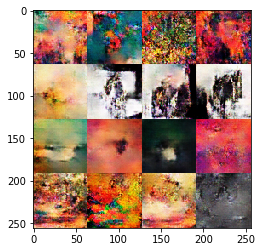

Model saved in path: ./tmp/model-64.ckpt
Epoch 14/500... Discriminator Loss: 0.3326... Generator Loss: 1.9700
Epoch 15/500... Discriminator Loss: 0.4505... Generator Loss: 1.6332
Epoch 17/500... Discriminator Loss: 0.3204... Generator Loss: 1.9455
Epoch 18/500... Discriminator Loss: 0.3924... Generator Loss: 1.6900
Epoch 19/500... Discriminator Loss: 0.6143... Generator Loss: 2.0916
Epoch 20/500... Discriminator Loss: 0.4536... Generator Loss: 1.6359
Epoch 22/500... Discriminator Loss: 0.3816... Generator Loss: 1.6425
Epoch 23/500... Discriminator Loss: 0.3890... Generator Loss: 1.5952
Epoch 24/500... Discriminator Loss: 0.3675... Generator Loss: 1.8809
Epoch 25/500... Discriminator Loss: 0.4313... Generator Loss: 1.4842
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


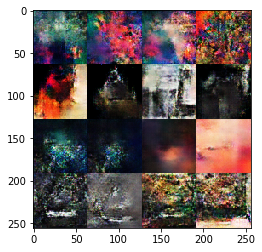

Model saved in path: ./tmp/model-64.ckpt
Epoch 27/500... Discriminator Loss: 1.0039... Generator Loss: 0.5786
Epoch 28/500... Discriminator Loss: 2.2787... Generator Loss: 0.1608
Epoch 29/500... Discriminator Loss: 0.4206... Generator Loss: 1.9663
Epoch 30/500... Discriminator Loss: 0.3930... Generator Loss: 1.7477
Epoch 32/500... Discriminator Loss: 0.3478... Generator Loss: 1.8516
Epoch 33/500... Discriminator Loss: 0.3439... Generator Loss: 1.8167
Epoch 34/500... Discriminator Loss: 0.3977... Generator Loss: 1.8232
Epoch 35/500... Discriminator Loss: 0.3765... Generator Loss: 1.6772
Epoch 37/500... Discriminator Loss: 0.3022... Generator Loss: 2.1698
Epoch 38/500... Discriminator Loss: 0.3724... Generator Loss: 1.6199
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


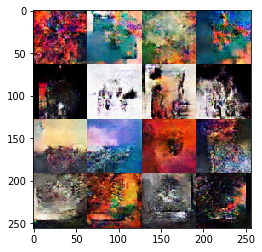

Model saved in path: ./tmp/model-64.ckpt
Epoch 39/500... Discriminator Loss: 0.3899... Generator Loss: 2.0273
Epoch 40/500... Discriminator Loss: 0.3790... Generator Loss: 1.7044
Epoch 42/500... Discriminator Loss: 0.3374... Generator Loss: 1.9064
Epoch 43/500... Discriminator Loss: 0.4515... Generator Loss: 1.4929
Epoch 44/500... Discriminator Loss: 0.4094... Generator Loss: 1.8215
Epoch 45/500... Discriminator Loss: 0.3303... Generator Loss: 2.0244
Epoch 47/500... Discriminator Loss: 0.8277... Generator Loss: 3.0437
Epoch 48/500... Discriminator Loss: 0.4791... Generator Loss: 1.3311
Epoch 49/500... Discriminator Loss: 0.3882... Generator Loss: 1.7392
Epoch 50/500... Discriminator Loss: 0.4104... Generator Loss: 1.5289
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


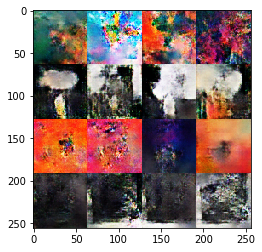

Model saved in path: ./tmp/model-64.ckpt
Epoch 52/500... Discriminator Loss: 0.3685... Generator Loss: 1.8133
Epoch 53/500... Discriminator Loss: 0.4344... Generator Loss: 1.4020
Epoch 54/500... Discriminator Loss: 0.3576... Generator Loss: 1.7540
Epoch 55/500... Discriminator Loss: 0.3227... Generator Loss: 2.1819
Epoch 57/500... Discriminator Loss: 0.4041... Generator Loss: 2.0954
Epoch 58/500... Discriminator Loss: 0.4504... Generator Loss: 1.3927
Epoch 59/500... Discriminator Loss: 0.6759... Generator Loss: 1.1030


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.3

epochs = 500

poster_dataset = helpers.Dataset('celeba', glob(os.path.join(data_dir, '*.jpg')))

with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, poster_dataset.get_batches,
          poster_dataset.shape, poster_dataset.image_mode)

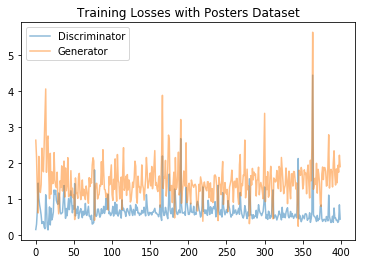

In [110]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with Posters Dataset")
plt.legend()